In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
pd.options.mode.chained_assignment = None  # default='warn'

## Configurations

In [2]:
rd = 5
start_week = Week(2021,18)
end_week = Week(2021,43)
max_date = datetime.datetime(2021, 6, 23)
models = ["Ensemble","Ensemble_LOP","IHME-IHME_COVID_model_deaths_unscaled","JHUAPL-Bucky","JHU_IDD-CovidSP","Karlen-pypm",
          "MOBS_NEU-GLEAM_COVID","UNCC-hierbin","USC-SIkJalpha","UVA-adaptive"]
# model = "Ensemble"
model = "MOBS_NEU-GLEAM_COVID"

In [3]:
# rd = 12
# start_week = Week(2022,2)
# end_week = Week(2022,13)
# max_date = datetime.datetime(2022, 3, 15) #variant
# models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
#           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]
# model = models[4]

In [4]:
# rd = 14
# start_week = Week(2022,23)
# end_week = Week(2023,22)
# max_date = None
# models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","MOBS_NEU-GLEAM_COVID_OT","NCSU-COVSIM",
#           "UNCC-hierbin","USC-SIkJalpha","USC-SIkJalpha-update","UTA-ImmunoSEIRS","UVA-adaptive"]
# model = "MOBS_NEU-GLEAM_COVID"
# # model = "Ensemble"

In [5]:
# target = 'death'
target = 'hosp'
incidence = True
target_location = 'US'

locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
location_mapping = dict()
for loc in locations['location']:
    location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

## Load and format surveillance data

In [6]:
if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]

#filter location
observations = observations[observations['location'] == target_location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

if max_date:
    observations = observations[observations['date'] <= max_date].copy()

#transform to Observation object
observations = Observations(observations)

/var/folders/9v/j2dwy_kx7c32vpw655tnps0r0000gp/T/ipykernel_14870/530478477.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()


## Load and filter a single model

In [7]:
target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" 
                          for i in range(1,len(observations)+1)]

In [8]:
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
predictions = predictions.merge(locations, how='inner', on='location')

In [9]:

#choose location
pred = predictions[predictions['location'] == target_location].copy()   

#filter target
pred = pred[(pred['target'].isin(target_prediction_list))]

#filter max date
if max_date:
    pred = pred[pred['target_end_date'] <= max_date]
    
if len(pred) == 0:
    raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

Split by scenarios

In [10]:
scenarios = list(pred['scenario_id'].drop_duplicates())
predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
med_ensemble_predictions = median_ensemble(predictions_list)
ex_ensemble_predictions = extreme_ensemble(predictions_list)
predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme aggregate"]
# print(labels)

/Users/g.st-onge/Projects/scorepi/scorepi/ensemble_models.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by=ind_cols + [type_col,quantile_col],dropna=False).median().reset_index()
/Users/g.st-onge/Projects/scorepi/scorepi/ensemble_models.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by=ind_cols + [type_col,quantile_col],dropna=False).median().reset_index()
/Users/g.st-onge/Projects/scorepi/scorepi/ensemble_models.py:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

## Plot

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
#intervals to show
intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [12]:
fontsize=14
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}\usepackage{sfmath}')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('axes', labelsize=fontsize)
color = '#17B1BF'

### Scenarios

In [13]:
target_loc_name = location_mapping[target_location]

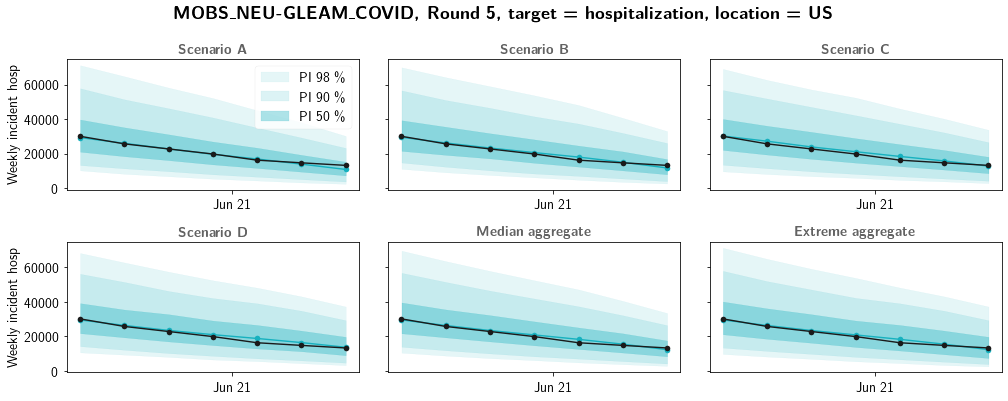

In [14]:
width = 7.057*2.
height = width/2.5
fig, axes = plt.subplots(2,3, figsize=(width, height), sharey=True)
plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.85, wspace=0.1,
                    hspace=0.4)
fig.suptitle(r"\textbf"+"{"+f"{model}, Round {rd}, target = {target_obs}, location = {target_loc_name}"+"}", fontsize=fontsize+4)
for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
    i = ind // 3
    j = ind % 3
    
    #title
    axes[i][j].set_title(r"\textbf"+"{"+f"{label}"+"}", fontsize=fontsize, color='#636363')

    t = np.unique(predictions.get_t())

    #intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes[i][j].fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                               label=fr"PI {int(round(interval_range*100))} \%")
    if i == 0 and j == 0:
        axes[i][j].legend(frameon=True, fontsize=fontsize)

    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes[i][j].plot(t,pred_point,'-o',color=color)
    
    #plot surveillance
    axes[i][j].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')
    
    #set x axis
    set_date_axis_fmt(axes[i][j])
    

    #set y axis 
    axes[i][0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
    
    
path = f"./figs/rd{rd}/{'inc' if incidence else 'cum'}_{target}/{target_loc_name}/"
Path(path).mkdir(parents=True, exist_ok=True)

plt.savefig(path+f"{model}.pdf")

## Calculate scores

In [15]:
from collections import defaultdict

In [16]:
timestamped_scores = dict()
aggregated_scores = dict()
for label,predictions in zip(labels,predictions_list):
    d,df = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
    timestamped_scores[label] = df
    aggregated_scores[label] = d

In [17]:
aggregated_data = defaultdict(list)
for label in labels:
    aggregated_data['Case'] += [label]
    aggregated_data['95% PI Coverage'] += [aggregated_scores[label]['95_cov']]
    aggregated_data['50% PI Coverage'] += [aggregated_scores[label]['50_cov']]
    aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
    aggregated_data['MAE'] += [aggregated_scores[label]['point_absolute_error_mean']]
    aggregated_data['WIS dispersion %'] += [100*aggregated_scores[label]['dispersion_wis_fraction']]
    aggregated_data['WIS underprediction %'] += [100*aggregated_scores[label]['underprediction_wis_fraction']]
    aggregated_data['WIS overprediction %'] += [100*aggregated_scores[label]['overprediction_wis_fraction']]

In [18]:
agg_data_df = pd.DataFrame(aggregated_data)
agg_data_df['Model'] = model
agg_data_df

,Case,95% PI Coverage,50% PI Coverage,WIS,MAE,WIS dispersion %,WIS underprediction %,WIS overprediction %,Model
0,Scenario A,1.0,1.0,2152.114711,718.751068,97.058068,0.294430,2.647502,MOBS_NEU-GLEAM_COVID
1,Scenario B,1.0,1.0,2172.567308,862.465337,97.496742,1.510408,0.992849,MOBS_NEU-GLEAM_COVID
2,Scenario C,1.0,1.0,2248.896963,1127.340842,97.171808,2.707774,0.120418,MOBS_NEU-GLEAM_COVID
3,Scenario D,1.0,1.0,2328.299689,1066.140455,97.159455,2.677552,0.162993,MOBS_NEU-GLEAM_COVID
4,Median aggregate,1.0,1.0,2209.961474,906.030399,97.707351,1.822912,0.469737,MOBS_NEU-GLEAM_COVID
5,Extreme aggregate,1.0,1.0,2554.585255,906.030399,98.457964,1.166247,0.375789,MOBS_NEU-GLEAM_COVID
